In [49]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

In [50]:
train = pd.read_csv('./data/train_data.csv')
valid = pd.read_csv('./data/valid_data.csv')
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
train = train.dropna()
valid = valid.dropna()

In [51]:
train.head()

,label,text,cleaned_text,cat_label,tokens
0,2,one night like in vegas i make dat nigga famous,one night like vegas make dat nigga famous,1,"['one', 'night', 'like', 'vegas', 'make', 'dat..."
1,2,walking through chelsea at this time of day is...,walking chelsea time day rather lovely love lo...,1,"['walking', 'chelsea', 'time', 'day', 'rather'..."
2,1,"and on the very first play of the night, aaron...",first play night aaron rodgers int udfa cb bra...,0,"['first', 'play', 'night', 'aaron', 'rodgers',..."
3,1,"drove the bike today, about 40 miles. felt lik...",drove bike today 40 miles felt like jim carrey...,0,"['drove', 'bike', 'today', '40', 'miles', 'fel..."
4,0,looking at the temp outside....hpw did it get ...,looking temp outside hpw get hotter sun goes f...,-1,"['looking', 'temp', 'outside', 'hpw', 'get', '..."


In [52]:
# Extract text and labels
train_texts = train['text'].tolist()
train_labels = train['cat_label'].map({1:2, 0:1, -1:0})
test_texts = valid['text'].tolist()
test_labels = valid['cat_label'].map({1:2, 0:1, -1:0})

vectorizer = TfidfVectorizer(max_features=15000) # Adjust max_features as needed
train_features = vectorizer.fit_transform(train_texts)
test_features = vectorizer.transform(test_texts)
joblib.dump(vectorizer, './vocab/tfidf_vectorizer.pkl')

['./vocab/tfidf_vectorizer.pkl']

In [53]:
def show_confusion_matrix(model_name, predictions):
    # Print confusion matrix
    confusion_matrix_model = confusion_matrix(test_labels, predictions)
    plt.figure(figsize=(7, 6))
    sns.heatmap(confusion_matrix_model, annot=True, fmt='d', cmap='YlOrRd',annot_kws={"size": 20, "color": "Black"})
    plt.title(f'Confusion Matrix ({model_name})', fontsize=18)
    plt.ylabel('Actual', fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    plt.xticks([0.5, 1.5, 2.5], ['Negative', 'Neutral', 'Positive'], fontsize=18,color
    = 'Red')
    plt.yticks([0.5, 1.5, 2.5], ['Negative', 'Neutral', 'Positive'], fontsize=18, color
    = 'Blue')
    plt.tight_layout()
    plt.show()

    return confusion_matrix_model

Training LR: 100%|██████████| 9/9 [00:11<00:00,  1.32s/it]


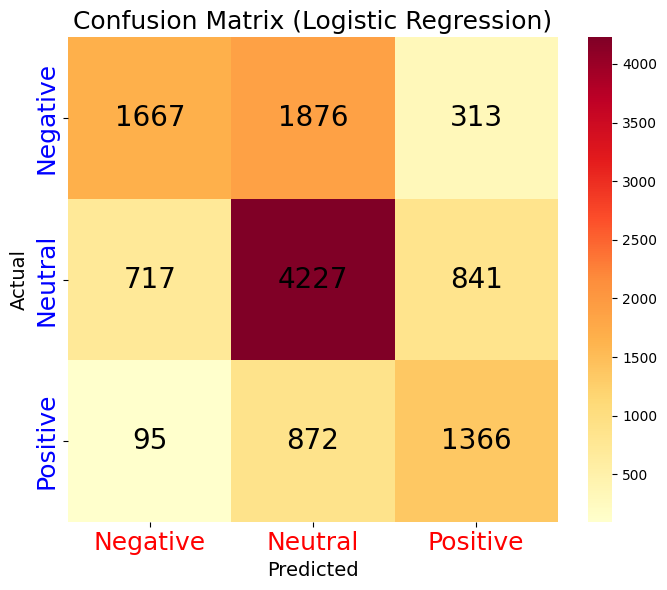

In [54]:
chunk_size = 5000  # Define chunk size
num_chunks = train_features.shape[0] // chunk_size
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
total_samples_processed = 0
for i in tqdm(range(num_chunks), desc='Training LR'):
    start = i * chunk_size
    end = (i + 1) * chunk_size
    chunk_features = train_features[start:end]
    chunk_labels = train_labels[start:end]
    lr.fit(train_features, train_labels)
    total_samples_processed += chunk_features.shape[0]
    
if train_features.shape[0] % chunk_size != 0:
    remaining_features = train_features[num_chunks * chunk_size:]
    remaining_labels = train_labels[num_chunks * chunk_size:]
    lr.fit(train_features, train_labels)
    total_samples_processed += remaining_features.shape[0]
    
lr_preds = lr.predict(test_features)
# Calculate accuracy
lr_acc = accuracy_score(test_labels, lr_preds)
cf_lr = show_confusion_matrix('Logistic Regression', lr_preds)

In [55]:
combined_data = pd.concat([train, valid], axis=0)
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)
combined_data = combined_data.dropna(subset=['label'])
X_combined = combined_data['text']
y_combined = combined_data['label'].map({1:2, 0:1, -1:0})
y_combined = y_combined.fillna(1) 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
vectorizer = TfidfVectorizer(max_features=15000)
lr_cv = LogisticRegression(solver='lbfgs', max_iter=1000)
cv_scores = []
for train_idx, val_idx in tqdm(cv.split(X_combined, y_combined)):
    # Split the data into training and validation sets
    X_train, X_val = X_combined.iloc[train_idx], X_combined.iloc[val_idx]
    y_train, y_val = y_combined.iloc[train_idx], y_combined.iloc[val_idx]
    
    # Vectorize the training data
    X_train_features = vectorizer.fit_transform(X_train)
    
    # Vectorize the validation data using the same vectorizer (to avoid leakage)
    X_val_features = vectorizer.transform(X_val)
    
    lr.fit(X_train_features, y_train)
    
    # Evaluate the model on the validation data
    score = lr.score(X_val_features, y_val)
    cv_scores.append(score)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {sum(cv_scores)/len(cv_scores)}")
lr_cv_acc = sum(cv_scores)/len(cv_scores)

5it [00:06,  1.40s/it]

Cross-validation scores: [0.6911561305019933, 0.697258156374583, 0.6944105443007078, 0.6926769731489015, 0.6923515052888527]
Mean accuracy: 0.6935706619230076


In [56]:
r = [[cf_lr[2,2] / cf_lr[2,:].sum(), cf_lr[1,1] / cf_lr[1,:].sum(), cf_lr[0,0] / cf_lr[0,:].sum()]]
recall_df = pd.DataFrame(r, columns=['positive', 'neutral', 'negetive'], index=['lr'])
p = [[cf_lr[2,2] / cf_lr[:,2].sum(), cf_lr[1,1] / cf_lr[:,1].sum(), cf_lr[0,0] / cf_lr[:,0].sum()]]
precision_df = pd.DataFrame(p, columns=['positive', 'neutral', 'negetive'], index=['lr'])
f1_scores = recall_df.copy()
for col in ['positive', 'neutral', 'negetive']:
    f1_scores[col] = 2 * (precision_df[col] * recall_df[col]) / (precision_df[col] + recall_df[col])

df_accuracies = pd.DataFrame({
    'accuracy': [lr_acc]
}, index=['lr'])
# Add a suffix to indicate F1 scores
f1_scores = f1_scores.rename(columns=lambda x: x if x == 'name' else f'F1_{x}')
results = pd.concat([df_accuracies, f1_scores], axis=1)
results


,accuracy,F1_positive,F1_neutral,F1_negetive
lr,0.606314,0.562951,0.662539,0.526283


In [57]:
results = pd.DataFrame({'accuracy': [lr_acc, lr_cv_acc]}, index=['LR Without CV', 'LR With CV'])
results

,accuracy
LR Without CV,0.606314
LR With CV,0.693571


In [58]:
joblib.dump(lr_cv, "./models/logistic_regression_model.pkl")
print("Logistic Regression model saved successfully.")

results.to_csv('LR_results.csv', index=False)

Logistic Regression model saved successfully.
